# Basic inference of a transmission string

In this tutorial we take a look at how to fit a light curve with a basic Markov chain Monte Carlo (MCMC) approach, and infer a distribution of transmission strings. As in the previous tutorial, let us start by simulating a transit light curve for a known 7-parameter transmission string.

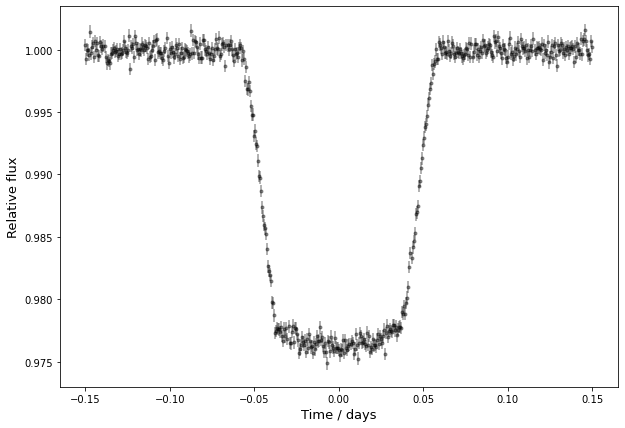

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(12)

times = np.linspace(-0.15, 0.15, 500)
r_mean = np.array([0.15])
r_dev = np.random.uniform(-0.1, 0.1, size=6)
injected_r = np.concatenate([r_mean, r_dev * r_mean])

ht = HarmonicaTransit(times)
ht.set_orbit(t0=0., period=4., a=11., inc=87. * np.pi / 180.)
ht.set_stellar_limb_darkening(np.array([0.027, 0.246]), limb_dark_law='quadratic')
ht.set_planet_transmission_string(injected_r)

theta = np.linspace(-np.pi, np.pi, 1000)
injected_transmission_string = ht.get_planet_transmission_string(theta)

flux_sigma = 500.e-6 * np.ones(times.shape[0])
flux_errs = np.random.normal(loc=0., scale=flux_sigma, size=times.shape[0])
observed_fluxes = ht.get_transit_light_curve() + flux_errs

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

This transit light curve corresponds to the following transmission string:

r = 0.150-0.010cos(t)+0.007sin(t)-0.007cos(2t)+0.001sin(2t)-0.015cos(3t)+0.013sin(3t)


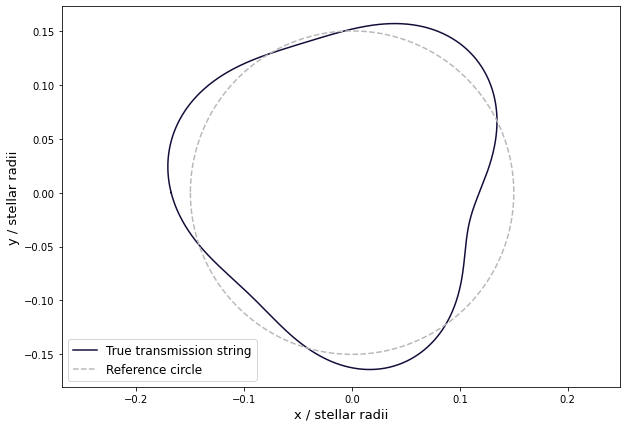

In [2]:
print("r = {0:.3f}{1:+.3f}cos(t){2:+.3f}sin(t)"
      "{3:+.3f}cos(2t){4:+.3f}sin(2t)"
      "{5:+.3f}cos(3t){6:+.3f}sin(3t)".format(*injected_r))

plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

Now you can apply Harmonica and sample the transmission string parameters. To do this we make use of the MCMC code, $\texttt{emcee}$.

In [3]:
import emcee


def log_prob(params):
    # Ln(prior).
    ln_prior = -0.5 * np.sum(((params[0] - 0.15) / 0.05)**2)
    ln_prior += -0.5 * np.sum((params[1:] / 0.1)**2)

    # Typical Gaussian ln(likelihood).
    ht.set_planet_transmission_string(params)
    model = ht.get_transit_light_curve()
    ln_like = -0.5 * np.sum((observed_fluxes - model)**2 / flux_sigma**2
                            + np.log(2 * np.pi * flux_sigma**2))

    return ln_like + ln_prior


coords = injected_r + 1.e-6 * np.random.randn(18, len(injected_r))
sampler = emcee.EnsembleSampler(coords.shape[0], coords.shape[1], log_prob)
state = sampler.run_mcmc(coords, 2000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 5000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:17<00:00, 10.04it/s]


For this example, the runtime of this method is over 11 minutes. If you are interested in potentially more efficient sampling methods, then checkout the tutorial on [gradient-based inference](<gradient_based_inference_transmission_string.html>).

Next, you can check the key metrics of this run and take a look at the posterior parameter distributions using $\texttt{arviz}$ and $\texttt{corner}$, respectively.

In [4]:
import arviz as az


emcee_data = az.from_emcee(sampler, 
                           var_names=["$a_0$", "$a_1$", "$b_1$", "$a_2$", 
                                      "$b_2$", "$a_3$", "$b_3$"])
az.summary(emcee_data, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$a_0$,0.14997,0.00049,0.14905,0.15083,0.00002,0.00002,597.50609,1288.90802,1.03484
$a_1$,-0.00820,0.00145,-0.01095,-0.00552,0.00006,0.00004,632.64520,1701.75242,1.03699
$b_1$,0.00730,0.00175,0.00397,0.01058,0.00006,0.00004,927.85854,1899.00101,1.02438
$a_2$,-0.00997,0.00638,-0.02209,0.00178,0.00026,0.00019,687.49741,1377.68028,1.03682
$b_2$,0.00209,0.00204,-0.00191,0.00582,0.00006,0.00005,1029.61370,2713.65107,1.02179
$a_3$,-0.01449,0.00515,-0.02415,-0.00501,0.00023,0.00016,508.94111,1840.61672,1.03138
$b_3$,0.01315,0.00392,0.00576,0.02044,0.00013,0.00009,913.52774,2313.72410,1.02280


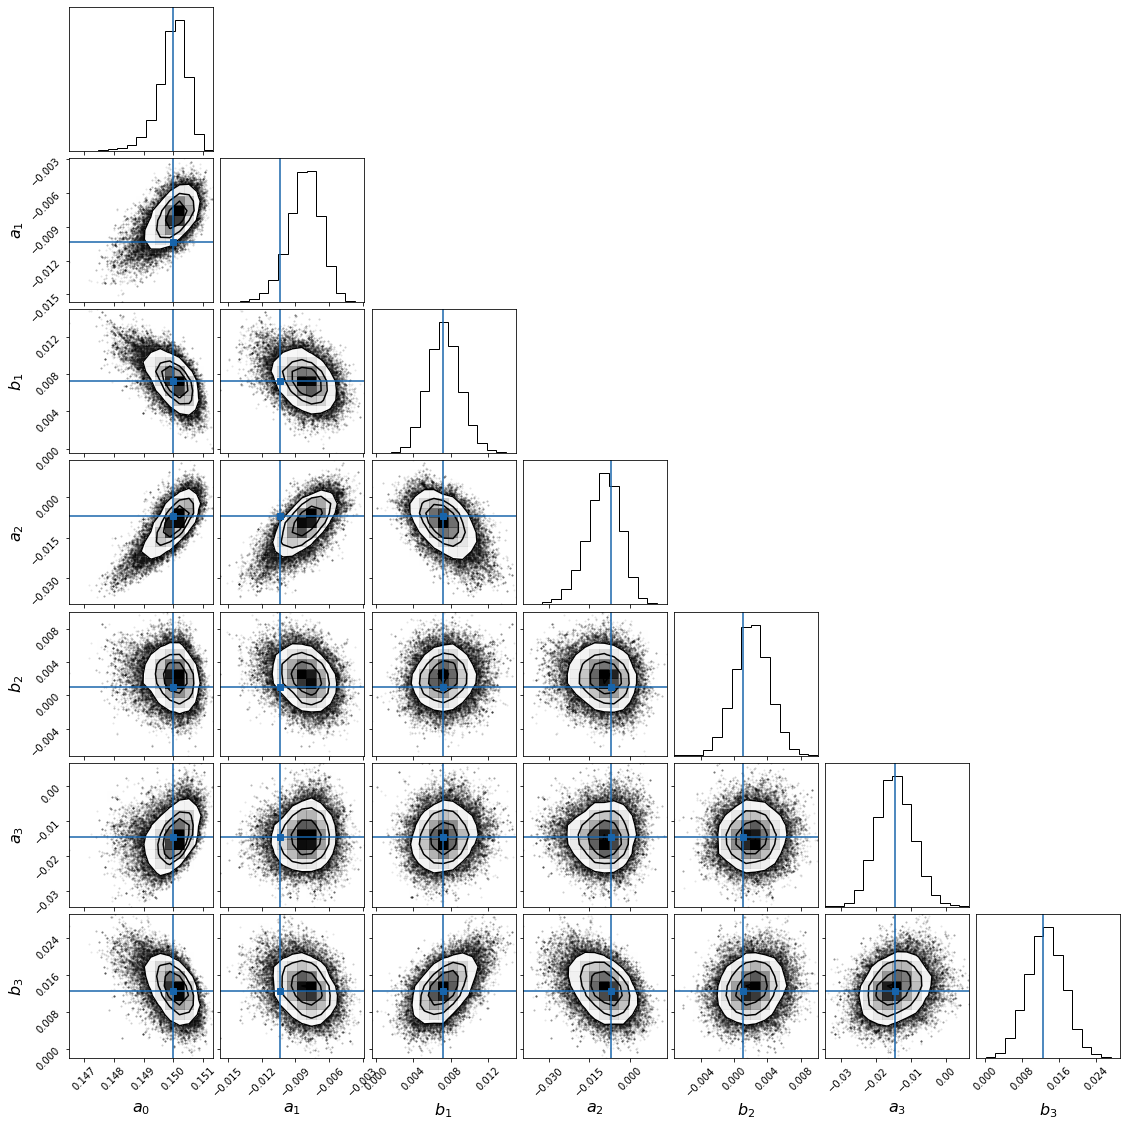

In [5]:
import corner


mcmc_r_samples = sampler.get_chain(flat=True)
figure = corner.corner(mcmc_r_samples, truths=injected_r, 
                       truth_color=cm.Blues(0.8), bins=15,
                       label_kwargs={"fontsize": 16},
                       labels=["$a_0$", "$a_1$", "$b_1$", "$a_2$", 
                               "$b_2$", "$a_3$", "$b_3$"])
plt.show()

You can sample the posteriors and plot realisations of the fitted transit light curve:

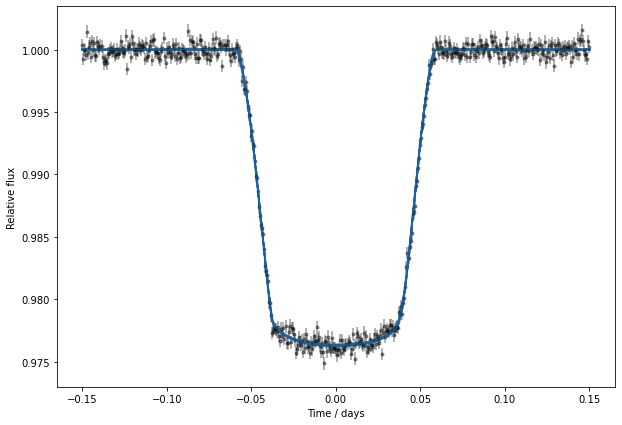

In [6]:
sample_idxs = np.random.randint(0, len(mcmc_r_samples), 150)

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4, zorder=1)
for r_sample in mcmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(times, ht.get_transit_light_curve(), c=cm.Blues(0.8), alpha=0.03, zorder=2)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

And here are sampled transmission strings:

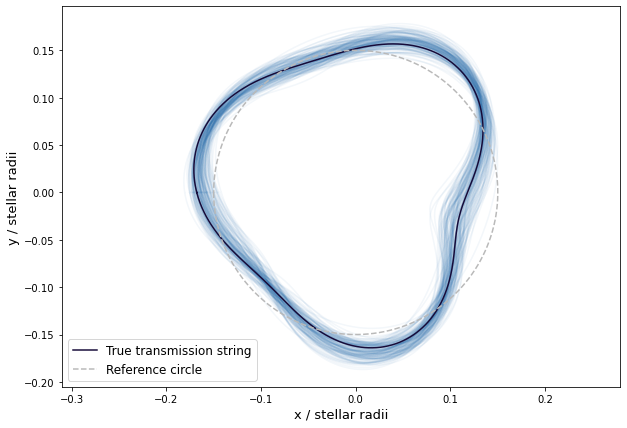

In [7]:
plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
for r_sample in mcmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(ht.get_planet_transmission_string(theta) * np.cos(theta), 
             ht.get_planet_transmission_string(theta) * np.sin(theta), 
             c=cm.Blues(0.8), alpha=0.05)
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

In polar coordinates:

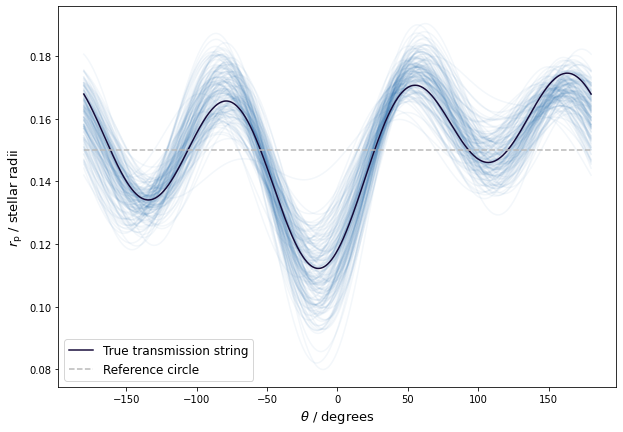

In [8]:
plt.figure(figsize=(10, 7))
for r_sample in mcmc_r_samples[sample_idxs]:
    ht.set_planet_transmission_string(r_sample)
    plt.plot(theta * 180. / np.pi, ht.get_planet_transmission_string(theta), 
             c=cm.Blues(0.8), alpha=0.05)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

From these samples, you can estimate the inferred distribution of transmission strings. Here you can see the injected transmission string is nicely recovered.

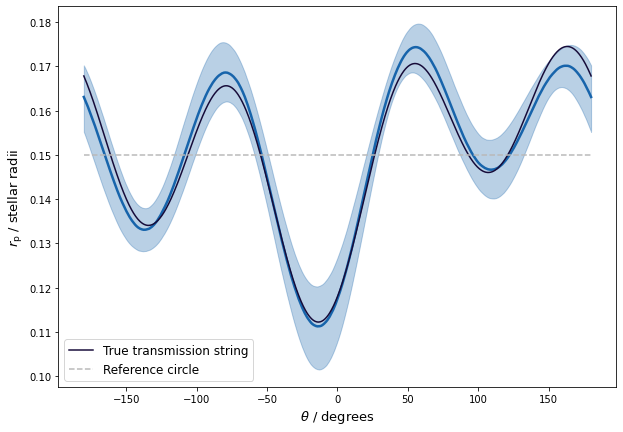

In [9]:
# Sample MCMC transmission string parameter distributions.
ht.set_planet_transmission_string(mcmc_r_samples)
ts_samples = ht.get_planet_transmission_string(theta)

# Get 16th, 50th, 84th percentiles.
ts_16, ts_50, ts_84 = np.percentile(ts_samples, [16., 50., 84.], axis=0)

plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, ts_50, c=cm.Blues(0.8), lw=2.5)
plt.fill_between(theta * 180. / np.pi, ts_16, ts_84, color=cm.Blues(0.8), alpha=0.3)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()